This notebook contains the  end to end pipeline for training and predicting on test

Here are the things we'll cover.
1. [EDA on data](#section-one)
2. [Data prep and feature generation](#section-two)
3. [TF-IDF and linear regression](#section-three)
4. [Catboost with text features](#section-four)
5. [Basic blend of model predictions](#section-five)


## Libraries 📚⬇

In [1]:
!pip install pymorphy2 -q

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm

#### TEXT PROCESSING
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from functools import lru_cache

#### MODELS
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MultiLabelBinarizer

import statsmodels.api as sm
from scipy.stats import norm
from scipy.sparse import hstack
import scipy.stats as stats

#### SETTINGS
plt.rcParams["figure.figsize"] = [10, 6]
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


<a id="section-one"></a>
# EDA on data

In [3]:
# Import data
df_train = pd.read_csv('../input/hse-2nd-step-in-nlp-bootcamp/vacancies_train.csv')
df_test = pd.read_csv('../input/hse-2nd-step-in-nlp-bootcamp/vacancies_test.csv', index_col=0)

In [4]:
df_train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


<AxesSubplot:xlabel='salary', ylabel='Count'>

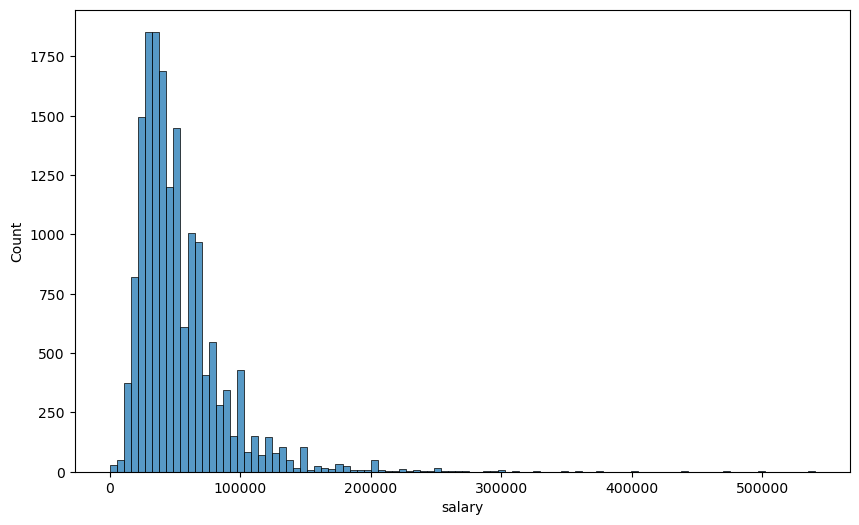

In [5]:
sns.histplot(df_train.salary, bins=100)

<AxesSubplot:xlabel='salary', ylabel='Count'>

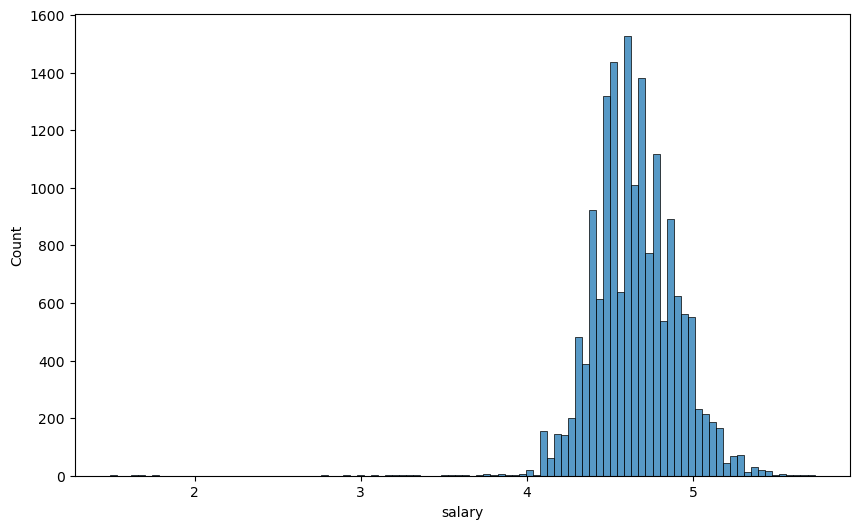

In [6]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [7]:
df_train[df_train['salary'] < 1000].shape[0]

7

In [8]:
df_train[df_train['salary'] < 1000]

,name,experience,schedule,employment,description,key_skills,salary
163,Ведущий специалист/Руководитель тендерного отдела,От 3 до 6 лет,Полный день,Полная занятость,Компания-поставщик медицинских расходных матер...,"['Государственные закупки', 'Тендеры', 'Участи...",55.0
1904,Официант на мероприятия,Нет опыта,Гибкий график,Частичная занятость,Группа компаний WIND TO GO! - это собственный ...,"['Работа в команде', 'Грамотная речь', 'Органи...",800.0
2641,Продавец консультант/старший(ТЦ Эльгрин),От 1 года до 3 лет,Полный день,Полная занятость,Должностные обязанности: - консультирование кл...,"['Клиентоориентированность', 'Мерчандайзинг', ...",30.0
9696,Фрезеровщик,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Обработка деталей на горизонталь...,"['Пользователь ПК', 'Работа в команде', 'Точно...",60.0
13252,Уборщица/уборщик игрового зала,Нет опыта,Сменный график,Полная занятость,Работа в ночные смены Обязанности: осуществля...,[],600.0
13491,Инженер-экономист,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности Работа с ресурсоснабжающими органи...,"['Работа с большим объемом информации', 'Делов...",45.0
16235,Комплектовщик (Тарасовка),Нет опыта,Сменный график,Полная занятость,Сервис доставки продуктов Ленточка приглашает ...,[],44.0


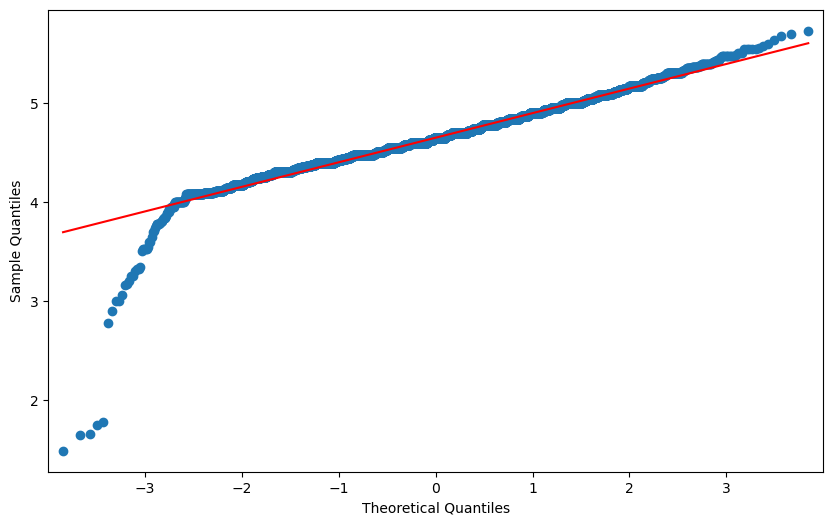

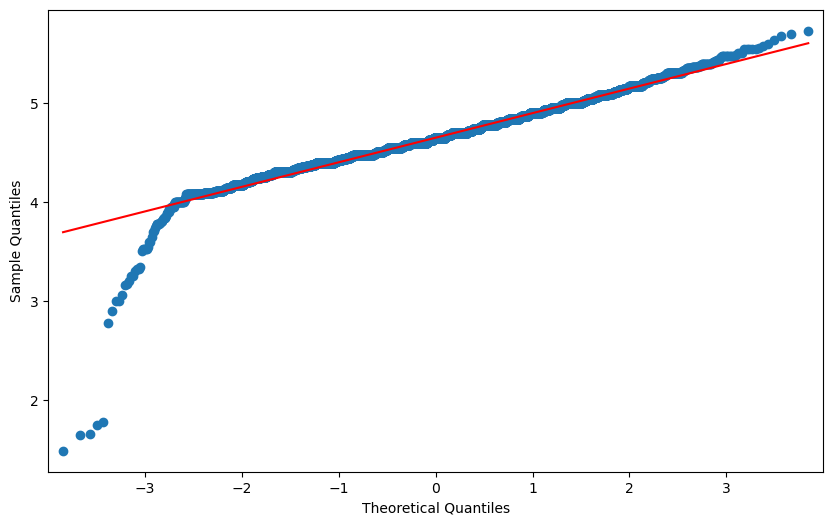

In [9]:
sm.qqplot(np.log10(df_train.salary + 1), line='s')

# Data prep and feature generation<a id="section-two">

## Correct errors in salary values

In [10]:
df_train['salary'][df_train['salary'] < 200] = df_train['salary'][df_train['salary'] < 200].apply(lambda x: x * 1000)

## Create a text column 

In [11]:
df_train['text'] = df_train.name + ' ' + df_train.description

## Clean text

In [12]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()
@lru_cache(maxsize=128)

# function for cleaning descriptions
def clean_text(text):
    text = re.sub(r'http\S+', ' ', text)# remove links
    text = re.sub(r'[^\w\s]', ' ', text)# remove punctuation
    text = word_tokenize(text.lower()) # convert to lowercase and tokenize by words
    # normalize tokens, remove stop words and short tokens
    text = [morph.normal_forms(token)[0] for token in text 
            if token not in stop_words and len(token) > 2]
    text = " ".join(text) # return a string
    return text

In [13]:
regenerate = False 

if regenerate: 
    df_train['clean_text'] = df_train.text.progress_apply(clean_text) 
    df_train['clean_name'] = df_train.name.progress_apply(clean_text)
    df_train['clean_skills'] = df_train.key_skills.progress_apply(clean_text)

    df_train[['clean_text',
              'clean_name',
              'clean_skills']].to_csv('train_cleaned_text_cols.csv', index=False) 
    
else:
    df_train_clean_text_cols = pd.read_csv('../input/2nd-step-cleaned-text/train_cleaned_text_cols.csv')
    df_train = pd.concat([df_train, df_train_clean_text_cols], axis=1)

## Some text features

In [14]:
def find_numbers(df, column_name):
    # find numbers that look like salariy in the descriptions
    
    df['found_numbers'] = df[column_name].str.extractall('(\d{3,4}00+)')\
        .astype(int).groupby(level=0).agg(list)
    # Drop any rows where no numbers were found
    new_df = df.dropna(subset=['found_numbers'])
    return new_df

def avg_max_func(x):
    '''if we find 2 or more numbers it could mean 
    we have salary range or some bonuses or incentives'''
    if isinstance(x, list):
        return pd.Series([sum(x)/len(x), max(x), min(x)])
    else:
        return pd.Series([x, x, x])

In [15]:
find_numbers(df_train, 'description')
df_train[['av_num', 'max_num', 'min_num']] = df_train['found_numbers'].apply(avg_max_func)

key_skills is a list of strings that is saved as a string

In [16]:
df_train['key_skills_list'] = df_train['key_skills'].apply(literal_eval)
df_train['num_skills'] = df_train['key_skills_list'].apply(len)

In [17]:
df_train['perc'] = df_train['description'].str.contains('процент').apply(int)
df_train['%'] = df_train['description'].str.contains('%').apply(int)
df_train['1s_text'] = df_train['description'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_train['1s_skills'] = df_train['key_skills'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_train['en_text'] = df_train['description'].str.contains(r'[A-Za-z]').apply(int)
df_train['en_skills'] = df_train['key_skills'].str.contains(r'[A-Za-z]').apply(int)
df_train['clean_skills'] = df_train['clean_skills'].fillna('')

In [18]:
df_train.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary', 'text', 'clean_text', 'clean_name',
       'clean_skills', 'found_numbers', 'av_num', 'max_num', 'min_num',
       'key_skills_list', 'num_skills', 'perc', '%', '1s_text', '1s_skills',
       'en_text', 'en_skills'],
      dtype='object')

In [19]:
categorical_features = [
    'experience',
    'schedule',
    'employment'
]

numerical_features = [
    'av_num', 
    'max_num', 
    'min_num',
    'num_skills'
]
features_to_drop = [
    'key_skills_list',
    'description',
    'found_numbers',
    'name',
    'key_skills', 
    'clean_name',         
    'clean_skills',      
    'clean_text',         
    'text',           
    'key_skills_list'  
]


# TF-IDF and linear regression<a id="section-three">

In [20]:
tfidf_words = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    lowercase=True,
    sublinear_tf=True
)
tfidf_chars = TfidfVectorizer(
    analyzer='char',
    ngram_range=(1, 5),
    lowercase=True,
    sublinear_tf=True
)

In [21]:
mlb = MultiLabelBinarizer()

# fit_transform on the column will return a numpy array with binary encoding
X_mlb = mlb.fit_transform(df_train['key_skills_list'])
X_mlb.shape

(16629, 4357)

In [22]:
X_tfidf_words = tfidf_words.fit_transform(df_train['clean_text'])
X_tfidf_chars = tfidf_chars.fit_transform(df_train['text'])

In [23]:
X_tfidf_chars.shape

(16629, 890609)

In [24]:
X_tfidf_words.shape

(16629, 516698)

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
    #('tfidf_words', tfidf_words, ['clean_text']),
    #('tfidf_chars', tfidf_chars, ['text']),
    ('categorical', OneHotEncoder(), categorical_features),
    #('skills_list', MyMultiLabelBinarizer(), ['key_skills_list']),
    ('numerical', MinMaxScaler(), numerical_features), 
    ('drop', 'drop', features_to_drop)
    ],
    remainder='passthrough',
)

X_proc = preprocessor.fit_transform(df_train.drop(columns=['salary']))
X_proc.shape

(16629, 23)

In [26]:
X_train = hstack([
    X_tfidf_words,
    X_tfidf_chars,
    X_mlb,
    X_proc
]).tocsr()
y_train = df_train['salary']
X_train.shape, y_train.shape

((16629, 1411687), (16629,))

In [27]:
nan_rows = np.isnan(X_train.data)
inf_rows = np.isinf(X_train.data)

# Replace NaN or infinity values with a finite number (e.g., 0)
X_train.data[nan_rows] = 0
X_train.data[inf_rows] = 0


In [28]:
model = Ridge(solver="sag", fit_intercept=True, random_state=42)
model.fit(X_train, y_train)

Ridge(random_state=42, solver='sag')

In [29]:
model.score(X_train, y_train)

0.9255747370963487

## Preparing test 

In [30]:
df_test['text'] = df_test.name + ' ' + df_test.description

In [31]:
regenerate = False  

if regenerate: 
    df_test['clean_text'] = df_test.text.progress_apply(clean_text) 
    df_test['clean_name'] = df_test.name.progress_apply(clean_text)
    df_test['clean_skills'] = df_test.key_skills.progress_apply(clean_text)

    df_test[['clean_text',
              'clean_name',
              'clean_skills']].to_csv('test_cleaned_text_cols.csv', index=False) 
    
else: 
    df_test_clean_text_cols = pd.read_csv('../input/2nd-step-cleaned-text/test_cleaned_text_cols.csv')
    df_test = pd.concat([df_test, df_test_clean_text_cols], axis=1)

In [32]:
find_numbers(df_test, 'description')
df_test[['av_num', 'max_num', 'min_num']] = df_test['found_numbers'].apply(avg_max_func)
df_test['key_skills_list'] = df_test['key_skills'].apply(literal_eval)
df_test['num_skills'] = df_test['key_skills_list'].apply(len)
df_test['perc'] = df_test['description'].str.contains('процент').apply(int)
df_test['%'] = df_test['description'].str.contains('%').apply(int)
df_test['1s_text'] = df_test['description'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_test['1s_skills'] = df_test['key_skills'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_test['en_text'] = df_test['description'].str.contains(r'[A-Za-z]').apply(int)
df_test['en_skills'] = df_test['key_skills'].str.contains(r'[A-Za-z]').apply(int)
df_test['clean_skills'] = df_test['clean_skills'].fillna('')

In [33]:
X_test_mlb = mlb.transform(df_test['key_skills_list'])
X_test_tfidf_words = tfidf_words.transform(df_test['clean_text'])
X_test_tfidf_chars = tfidf_chars.transform(df_test['text'])
X_test_proc = preprocessor.transform(df_test)
X_test_mlb.shape, X_test_tfidf_words.shape, X_test_tfidf_chars.shape, X_test_proc.shape

((5543, 4357), (5543, 516698), (5543, 890609), (5543, 23))

In [34]:
X_test = hstack([
    X_test_tfidf_words,
    X_test_tfidf_chars,
    X_test_mlb,
    X_test_proc
]).tocsr()

In [35]:
nan_rows = np.isnan(X_test.data)
inf_rows = np.isinf(X_test.data)


X_test.data[nan_rows] = 0
X_test.data[inf_rows] = 0

## Making predictions

In [36]:
pred_lin = model.predict(X_test)

<AxesSubplot:ylabel='Count'>

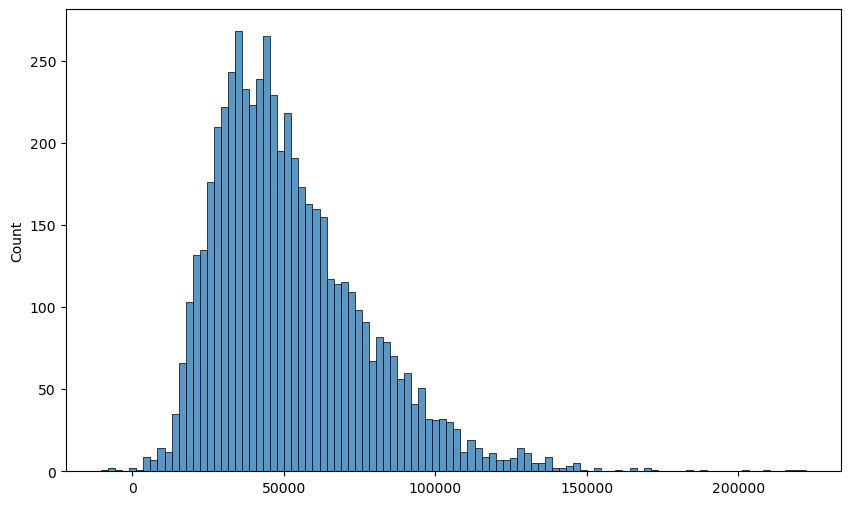

In [37]:
sns.histplot(pred_lin, bins=100)

## Making a submission

In [38]:
def pred_to_csv(pred, name):
    #pred[pred < 100] = 1000
    a = pd.Series(pred, name="salary")
    a.index.name = "id"
    a.to_csv(f"/kaggle/working/{name}.csv")

In [39]:
pred_to_csv(pred_lin, "ridge_tfidf") # LB 0.51644

# Catboost with text features<a id="section-four">

In [40]:
!pip install catboost -q
print('Done!')

Done!


In [41]:
from catboost import Pool, CatBoostRegressor

In [42]:
text_features = [
    'clean_name', 
    'text', 
    'clean_text', 
    'clean_skills'
]

features_to_drop_catboost = [
    'key_skills_list',
    'description',
    'found_numbers',
    'name',
    'key_skills',                     
    'key_skills_list'      
]

In [43]:
df_train_mlb = pd.DataFrame(X_mlb, columns=mlb.classes_)

# concatenate the new dataframe with the original dataframe
df_train = pd.concat([df_train, df_train_mlb], axis=1)

In [44]:
X_train_catboost, X_val_catboost, y_train_catboost, y_val_catboost = train_test_split(
    df_train.drop(columns = ['salary'] + features_to_drop_catboost),
    df_train['salary'], 
    train_size=0.95
    )

In [45]:
cat = CatBoostRegressor(
    use_best_model= True,
    learning_rate=0.03,
    task_type='GPU',
    depth = 6,
    iterations = 10000
    )

In [46]:
train_pool = Pool(
    X_train_catboost, y_train_catboost, 
    cat_features=categorical_features,
    text_features=text_features,
)

validation_pool = Pool(
    X_val_catboost, y_val_catboost, 
    cat_features=categorical_features,
    text_features=text_features,
)

In [47]:
cat.fit(
    train_pool, 
    eval_set = validation_pool,
    verbose = 200
) 

0:	learn: 34034.5817317	test: 34890.6575108	best: 34890.6575108 (0)	total: 48.2ms	remaining: 8m 1s
200:	learn: 25695.6457383	test: 28324.7460604	best: 28324.7460604 (200)	total: 7.43s	remaining: 6m 2s
400:	learn: 24340.1230495	test: 27688.5727943	best: 27688.5727943 (400)	total: 14s	remaining: 5m 34s
600:	learn: 23544.5386014	test: 27399.4554915	best: 27391.9496764 (597)	total: 20.5s	remaining: 5m 20s
800:	learn: 23032.2275595	test: 27267.6819471	best: 27261.0673757 (794)	total: 26.9s	remaining: 5m 8s
1000:	learn: 22729.3060651	test: 27193.3906902	best: 27192.8432214 (999)	total: 34s	remaining: 5m 5s
1200:	learn: 22360.8273277	test: 27117.1080827	best: 27111.3821570 (1188)	total: 40.4s	remaining: 4m 56s
1400:	learn: 22022.3354814	test: 27037.6665356	best: 27037.5601994 (1397)	total: 46.7s	remaining: 4m 46s
1600:	learn: 21697.4459498	test: 26998.7778641	best: 26996.1928256 (1579)	total: 53.1s	remaining: 4m 38s
1800:	learn: 21427.9546095	test: 26968.7385062	best: 26968.4756365 (1791)	tot

In [48]:
df_test_mlb = pd.DataFrame(X_test_mlb, columns=mlb.classes_)

# concatenate the new dataframe with the original dataframe
df_test = pd.concat([df_test, df_test_mlb], axis=1)

In [49]:
test_pool = Pool(
    df_test.drop(columns = features_to_drop_catboost),
    cat_features=categorical_features,
    text_features=text_features,
)

In [50]:
df_test.drop(columns = features_to_drop_catboost).shape

(5543, 4374)

In [51]:
df_train.drop(columns = features_to_drop_catboost).shape

(16629, 4375)

## Making a submission

In [52]:
pred_catboost = cat.predict(test_pool)

<AxesSubplot:ylabel='Count'>

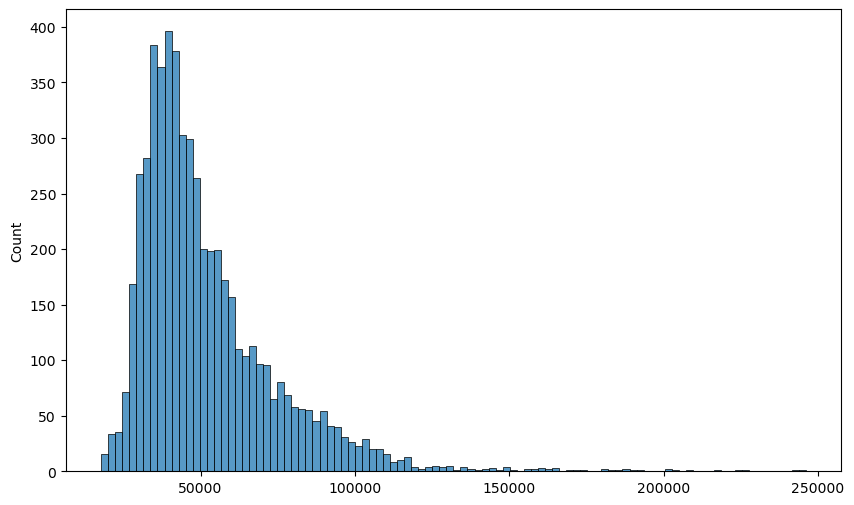

In [53]:
sns.histplot(pred_catboost, bins=100)

In [54]:
pred_to_csv(pred_catboost, "catboost") # LB 0.49764

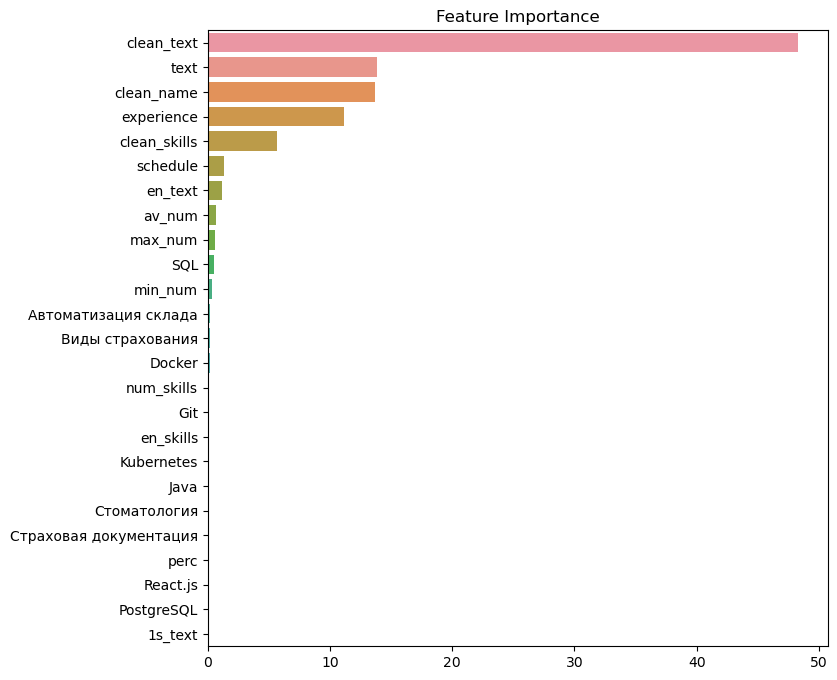

In [55]:
CAT_FI = cat.get_feature_importance()
feat_dict = {}
for col, val in sorted(zip(df_test.drop(
        columns=features_to_drop_catboost).columns, CAT_FI),
        key=lambda x: x[1], reverse=True):
    feat_dict[col] = val

feat_df = pd.DataFrame(
    {'Feature': feat_dict.keys(), 'Importance': feat_dict.values()})[:25]


values = feat_df.Importance
plt.rcParams["figure.figsize"] = (8, 8)
idx = feat_df.Feature
fig, ax = plt.subplots()
sns.barplot(y=idx, x=values).set(title='Feature Importance')
ax.set(xlabel='', ylabel='')
plt.show()

# Pretrained tinyBERT on text<a id="section-four">

In [56]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

pretrained_model = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
config = AutoConfig.from_pretrained(pretrained_model)
model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


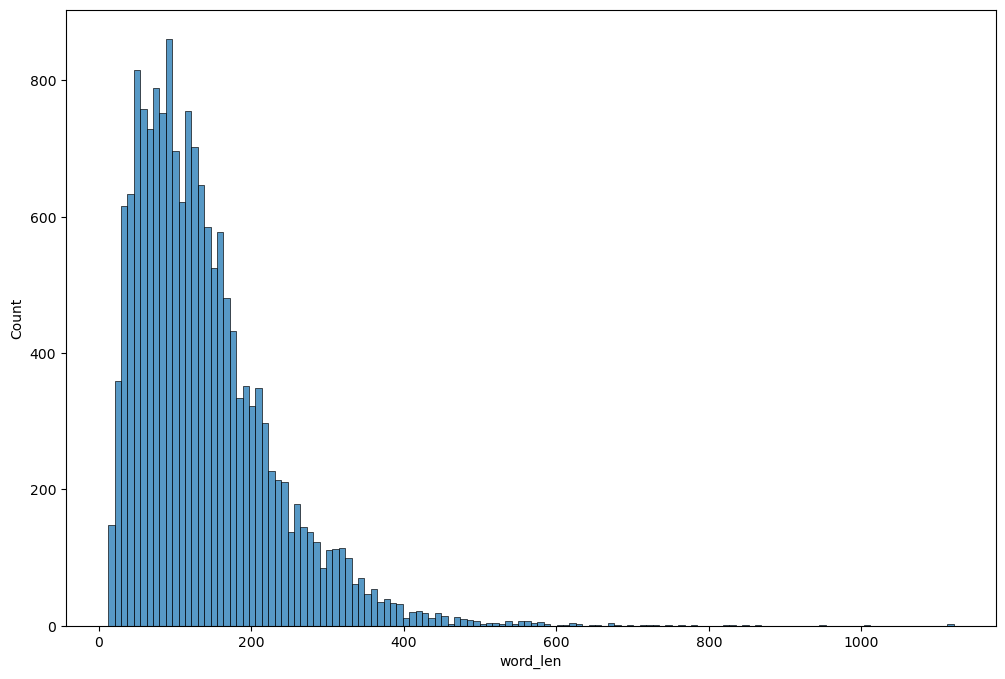

In [57]:
df_train['word_len'] = df_train.description.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train.word_len)
plt.show()

In [58]:
train_tokens = tokenizer((df_train.text).tolist(),
                   add_special_tokens=True,
                   padding='max_length',
                   truncation='longest_first',
                   max_length=512,
                   return_attention_mask=True,
                   return_tensors='pt'
                   )

In [59]:
input_ids = train_tokens['input_ids']
attention_mask = train_tokens['attention_mask']
input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = df_train.salary.to_numpy()

In [60]:
train_size = 0.9
seed = 42

train_inputs, val_inputs, train_labels, val_labels, train_indices, val_indices = \
    train_test_split(
        input_ids,
        labels,
        np.arange(labels.size),
        train_size=train_size,
        random_state=seed
    )

train_masks, val_masks, _, _ = train_test_split(
    attention_mask,
    labels,
    train_size=train_size,
    random_state=seed
)

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_labels.reshape(-1, 1))
train_labels = scaler.transform(train_labels.reshape(-1, 1))
val_labels = scaler.transform(val_labels.reshape(-1, 1))

In [62]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

def create_dataloaders(inputs, masks, labels, batch_size, shuffle=True):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=shuffle)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
val_dataloader = create_dataloaders(val_inputs, val_masks, 
                                     val_labels, batch_size, shuffle=False)

In [63]:
import torch.nn as nn

class TinyBERT(nn.Module):
    
    def __init__(self, drop_rate=0.2):
        
        super().__init__()
        
        self.transferred = model
        self.output = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(312, 1))
        
    def forward(self, input_ids, attention_masks):
        
        outputs = self.transferred(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.output(class_label_output)
        
        return outputs


In [64]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
print("")

Using GPU.



In [65]:
import pytorch_lightning as pl
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchmetrics import R2Score
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

class Regressor(pl.LightningModule):
    
    def __init__(self, model, lr=5e-5, eps=1e-8, n_epochs=10):
        super().__init__()
        
        self.model = model
        self.optimizer = AdamW(self.model.parameters(), lr=lr, eps=eps)
        self.loss = nn.MSELoss()
        self.eps = eps
        
    def forward(self, inp, mask):
        return self.model(inp, mask)
    
    def training_step(self, tr_batch, batch_idx):
        
        inputs, masks, labels = tr_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze().float(), labels.squeeze().float())
        score = r2_loss(outputs, labels)
        
        self.log(
            "train_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_r2",
            score,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        
        return loss
    
    def validation_step(self, val_batch, batch_idx) -> None:
        
        inputs, masks, labels = val_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze(), labels.squeeze())
        score = r2_loss(outputs, labels)
        
        self.log(
            "val_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "val_r2",
            score,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        
        return loss.float()
    
    def configure_optimizers(self):
        return {"optimizer": self.optimizer,
                "monitor": "r2"}

In [66]:
import random
import os

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [67]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
bert = TinyBERT(drop_rate=0.5)
model_nn = Regressor(bert).to(device)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu",
    #callbacks=[EarlyStopping(monitor="val_r2", mode="min", patience=2)]
)

trainer.fit(model_nn, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [68]:
torch.save(model_nn, "rubert-tiny")

In [69]:
# model_nn = Regressor(bert).to(device)

# checkpoint = torch.load("/kaggle/input/2nd_step_nns/rubert-tiny")
# model_nn.load_state_dict(checkpoint['model_state_dict'])

In [70]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
            tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model.model(batch_inputs,
                                  batch_masks).view(1, -1).tolist()[0]
    return output


In [71]:
test_tokens = tokenizer(
                        text=(df_test.text).tolist(),
                        add_special_tokens=True,
                        padding='max_length',
                        truncation='longest_first',
                        max_length=512,
                        return_attention_mask=True,
                        return_tensors='pt'
                        )
test_input_ids = np.array(test_tokens['input_ids'])
test_attention_mask = np.array(test_tokens['attention_mask'])

test_dataloader = create_dataloaders(
                                     test_input_ids,
                                     test_attention_mask,
                                     np.ones(test_input_ids.shape[0]),
                                     batch_size,
                                     shuffle=False
                                     )

In [72]:
pred_bert_scaled = predict(model_nn.to(device), test_dataloader, device)
pred_bert = scaler.inverse_transform(np.array(pred_bert_scaled).reshape(-1, 1)).flatten()

<AxesSubplot:ylabel='Count'>

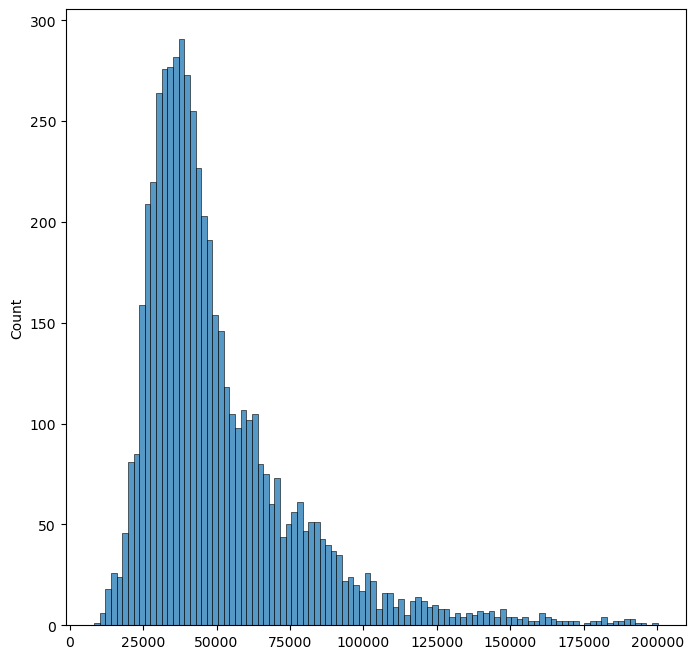

In [73]:
sns.histplot(pred_bert, bins=100)

In [74]:
pred_to_csv(pred_bert, "rubert-tiny") # LB 0.52732

# Basic blend of model predictions<a id="section-five">

In [75]:
basic_blend = (pred_lin + pred_catboost + pred_bert) / 3
pred_to_csv(basic_blend, "blend") # LB 0.57189